In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated, List
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()
openai_model = os.getenv("OPENAI_MODEL", "gpt-4o-mini")

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
search_tool = TavilySearchResults(max_results=2)
search_tool.invoke("LangGraph가 무엇인가요?")

[{'title': 'LangGraph란? - Dev studying blog - 티스토리',
  'url': 'https://dev-studyingblog.tistory.com/112',
  'content': 'LangGraph는 LangChain을 기반으로 만든 멀티에이전트 및 워크플로우 자동화 프레임워크이다. 쉽게 말해 AI 모델 간의 협업을 가능하게 하는 시스템',
  'score': 0.87981987},
 {'title': 'langgraph 소개 및 기본개념 : 네이버 블로그',
  'url': 'https://blog.naver.com/pjt3591oo/223861729229?fromRss=true&trackingCode=rss',
  'content': 'LangGraph는 LangChain 상태계의 일부로 LLM 애플리케이션의 흐름을 그래프로 정의하고 실행하는 라이브러리입니다. 여기서 그래프는 CS(Computer Science)',
  'score': 0.87807417}]

In [4]:
from langchain_core.tools import tool
from langgraph.types import interrupt

@tool
def human_assist(query):
    """Human assist tool"""
    human_response = interrupt({"query": query})
    return human_response["data"]

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [6]:
llm = ChatOpenAI(model=openai_model)
tools = [search_tool, human_assist]
llm_with_tools = llm.bind_tools(tools)

In [7]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [8]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [9]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools)
workflow = StateGraph(State)
workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", tool_node)
workflow.add_conditional_edges("chatbot", tools_condition)
workflow.add_edge("tools", "chatbot")
workflow.add_edge(START, "chatbot")
graph = workflow.compile(checkpointer=memory)

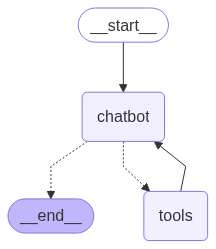

In [10]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
config = {"configurable": {"thread_id": "user123"}}

In [12]:
from pprint import pprint
snapshot = graph.get_state(config)
if 'messages' in snapshot.values:
    pprint(snapshot.values['messages'])
else:
    print("No messages found in the snapshot.")
print(snapshot.next)

No messages found in the snapshot.
()


In [13]:
user_input1 = "AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요."
state1 = {"messages": [HumanMessage(content=user_input1)]}
response1 = graph.invoke(state1, config)
print(response1["messages"][-1].content)

LangGraph는 AI 에이전트 개발을 위한 강력한 프레임워크로 여러 특징을 가지고 있습니다:

1. **Multi Agent 시스템**: LangGraph는 Amazon Bedrock과의 통합을 통해 정교한 AI 애플리케이션을 구성할 수 있는 Multi Agent 시스템 개발에 최적화되어 있습니다. 이 시스템은 에이전트 간의 오케스트레이션, 상태 관리, 오류 처리, 그리고 인간의 개입(human-in-the-loop) 기능을 지원합니다.

2. **상태 관리**: LangGraph는 애플리케이션의 상태를 유지하여 사용자 간의 상호작용 및 이전 상호작용의 대화 기억을 지원합니다. 상태 체크포인트를 통해 실행 중에 중단하고 재개하는 것이 가능하여, 인간의 입력을 통해 중요한 결정이나 수정을 수행할 수 있습니다.

3. **LangGraph Studio**: 이 통합 개발 환경(IDE)은 AI 에이전트 개발을 위해 특별히 설계되어, 시각화, 라이브 상호작용, 디버깅 기능 등을 제공합니다. 복잡한 에이전트 간의 상호작용을 효율적으로 설계하고 유지할 수 있게 해줍니다.

4. **오케스트레이션 아키텍처**: LangGraph는 상태 머신과 방향성 그래프를 사용하여 에이전트의 동작 및 애플리케이션의 흐름을 세밀하게 제어합니다. 에이전트의 동작은 상태(State), 노드(Nodes), 엣지(Edges)로 구성되며, 이를 통해 로직을 정의하고 결정할 수 있습니다.

5. **중앙 지속성 계층**: LangGraph는 대부분의 에이전트 아키텍처에서 필요로 하는 기능을 제공하는 중앙 지속성 계층을 구현하고 있어, 이러한 기능들을 공통적으로 사용할 수 있게 합니다.

이런 특성들 덕분에 LangGraph는 AI 에이전트 시스템을 효과적으로 구축하고 관리할 수 있는 강력한 도구로 자리 잡고 있습니다.


In [14]:
snapshot = graph.get_state(config)
if 'messages' in snapshot.values:
    pprint(snapshot.values['messages'])
else:
    print("No messages found in the snapshot.")
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='5dca40bb-10a2-45b3-9ade-54f31f4cae6a'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TWXySqInhGiqPln6NIoekqzI', 'function': {'arguments': '{"query":"LangGraph AI 에이전트 개발 특징"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 115, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnJ9tIxMVJUNeVbxNPQW03WjZmRwH', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--84ee02fb-5ab1-41f6-8329-cbce229c6b28-0', tool_calls=[{'name': 'tavily_search_result

In [15]:
user_input2 = "AI 에이전트 개발을 위한 기술 선택에 대한 전문가의 지원이 필요해요. 지원 요청을 해도 될까요?"
state2 = {"messages": [HumanMessage(content=user_input2)]}
response2 = graph.invoke(state2, config)
print(response2["messages"][-1].content)

In [16]:
snapshot = graph.get_state(config)
if 'messages' in snapshot.values:
    pprint(snapshot.values['messages'])
else:
    print("No messages found in the snapshot.")
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='5dca40bb-10a2-45b3-9ade-54f31f4cae6a'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TWXySqInhGiqPln6NIoekqzI', 'function': {'arguments': '{"query":"LangGraph AI 에이전트 개발 특징"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 115, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnJ9tIxMVJUNeVbxNPQW03WjZmRwH', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--84ee02fb-5ab1-41f6-8329-cbce229c6b28-0', tool_calls=[{'name': 'tavily_search_result

In [17]:
from langgraph.types import Command

human_response = (
    "네, 물론입니다. AI 에이전트 개발을 위한 기술 선택에 대한 지원을 해드리겠습니다. "
    "우선 LangGraph를 사용하는 것에 대해 어떻게 생각하시나요? "
    "LangGraph는 AI 에이전트를 개발하는 데 매우 유용한 도구입니다. "
)
human_command = Command(resume={"data": human_response})
response = graph.invoke(human_command, config)
print(response["messages"][-1].content)

네, AI 에이전트 개발을 위한 기술 선택에 대한 지원을 요청하셔도 좋습니다. LangGraph는 AI 에이전트 개발에 매우 유용한 도구로, 위에서 언급한 다양한 특징들이 이를 뒷받침합니다. 

여기에 더해, 전문적인 지원을 받으려면 프로젝트의 요구사항이나 목표에 대한 정보를 제공해 주시면 더욱 맞춤형 조언을 드릴 수 있습니다. 어떤 기술이나 플랫폼에 관심이 있으신지, 또는 특정한 문제를 해결하고자 하는 부분이 있는지 알려주시면 좋겠습니다.


In [18]:
snapshot = graph.get_state(config)
pprint(snapshot.values['messages'])
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='5dca40bb-10a2-45b3-9ade-54f31f4cae6a'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TWXySqInhGiqPln6NIoekqzI', 'function': {'arguments': '{"query":"LangGraph AI 에이전트 개발 특징"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 115, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnJ9tIxMVJUNeVbxNPQW03WjZmRwH', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--84ee02fb-5ab1-41f6-8329-cbce229c6b28-0', tool_calls=[{'name': 'tavily_search_result

In [19]:
user_input3 = "앞서 추천해주신 기술의 시장성은 어떤가요?"
state3 = {"messages": [HumanMessage(content=user_input3)]}
response3 = graph.invoke(state3, config)
print(response3["messages"][-1].content)

LangGraph의 시장성은 다음과 같은 여러 측면에서 강점을 보이고 있습니다:

1. **비즈니스 자동화 수요 증가**: LangGraph는 비즈니스 프로세스를 자동화하는 데 특히 유용한 도구로, AI 에이전트 개발에 필요한 다양한 기능을 제공합니다. 이는 기업들이 효율성을 극대화하고 비용을 절감하는 데 기여할 수 있어, 시장에서의 수요가 높습니다.

2. **유연한 개발 플랫폼**: LangGraph는 대규모 언어 모델(LLM) 기술을 접목하여 고급 에이전트 설계가 가능하며, 이를 통해 다양한 산업군에서 활용될 수 있는 유연성을 가지고 있습니다. 멀티에이전트 구조와 복잡한 로직을 지원하기 때문에 복잡한 비즈니스 환경에서도 적응력이 뛰어난 솔루션을 제공합니다.

3. **확장성**: LangGraph는 상태 관리, 메모리 기능 등 다수의 기본 기능을 제공함으로써 확장 가능성이 뛰어납니다. 이는 에이전트가 시간이 지남에 따라 학습하고 발전할 수 있는 기반을 마련해 줍니다.

4. **지속적인 교육 및 자원 제공**: LangGraph에 대한 교육 자료와 GitHub와 같은 플랫폼을 통한 실습 자료는 사용자들에게 실질적인 도움이 됩니다. 이러한 자료는 개인이나 기업이 LangGraph를 효과적으로 활용할 수 있도록 돕고, 시장에서의 수요를 더욱 촉진시킬 수 있습니다.

5. **기술적 혁신**: LangGraph와 MCP 같은 기술의 조합은 AI 에이전트 개발의 새로운 패러다임을 제시하고 있으며, 이는 비즈니스 자동화의 새로운 시대를 여는 결과를 가져올 가능성이 높습니다.

이러한 요소들이 결합되어 LangGraph는 AI 에이전트 개발 분야에서 상당한 시장성을 지니고 있으며, 기업과 개발자들이 이를 활용하여 효과적으로 비즈니스 솔루션을 구축하는 데 큰 기여를 할 것으로 예상됩니다.


In [20]:
snapshot = graph.get_state(config)
pprint(snapshot.values['messages'])
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='5dca40bb-10a2-45b3-9ade-54f31f4cae6a'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TWXySqInhGiqPln6NIoekqzI', 'function': {'arguments': '{"query":"LangGraph AI 에이전트 개발 특징"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 115, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnJ9tIxMVJUNeVbxNPQW03WjZmRwH', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--84ee02fb-5ab1-41f6-8329-cbce229c6b28-0', tool_calls=[{'name': 'tavily_search_result

In [21]:
user_input4 = "LangGraph의 메모리 기능 추가에 대한 전문가의 지원이 필요해요."
state4 = {"messages": [HumanMessage(content=user_input4)]}
response4 = graph.invoke(state4, config)
print(response4["messages"][-1].content)

In [22]:
snapshot = graph.get_state(config)
if 'messages' in snapshot.values:
    pprint(snapshot.values['messages'])
else:
    print("No messages found in the snapshot.")
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='5dca40bb-10a2-45b3-9ade-54f31f4cae6a'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TWXySqInhGiqPln6NIoekqzI', 'function': {'arguments': '{"query":"LangGraph AI 에이전트 개발 특징"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 115, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnJ9tIxMVJUNeVbxNPQW03WjZmRwH', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--84ee02fb-5ab1-41f6-8329-cbce229c6b28-0', tool_calls=[{'name': 'tavily_search_result

In [23]:
human_response = (
    "MemorySaver는 메모리 기반의 체크포인터로, 각 대화의 상태를 메모리에 임시로 저장하고 관리합니다. "
    "이를 통해 챗봇은 이전 대화 내용을 기억하고 다음 번 상호작용 시에도 맥락을 유지한 상태로 대화를 진행할 수 있습니다. "
    "실제 운영 환경에서는 더 영구적인 상태 관리를 위해 데이터베이스 기반 체크포인터(예: SqliteSaver 또는 PostgresSaver)를 사용하는 것이 권장됩니다."
)
human_command = Command(resume={"data": human_response})
response = graph.invoke(human_command, config)
print(response["messages"][-1].content)

LangGraph의 메모리 기능 추가에 대한 지원을 요청하셨군요. 메모리 기능은 AI 에이전트가 이전 대화 내용을 기억하고 다음 상호작용 시에도 맥락을 유지할 수 있게 도와주는 중요한 요소입니다.

1. **MemorySaver 사용**: LangGraph에서는 기본적으로 MemorySaver를 사용할 수 있습니다. 이 기능은 메모리 기반의 체크포인터로, 각 대화의 상태를 임시로 저장하고 관리하여 챗봇이 이전 대화 내용을 기억할 수 있도록 합니다.

2. **영구적인 상태 관리**: 실제 운영 환경에서는 보다 영구적인 상태 관리를 위해 데이터베이스 기반의 체크포인터를 사용하는 것이 권장됩니다. 예를 들어, SqliteSaver 또는 PostgresSaver와 같은 옵션을 통해 데이터를 지속적으로 저장하고 관리할 수 있습니다.

3. **상태 관리의 중요성**: 메모리 기능을 효과적으로 활용하면 에이전트의 성능을 크게 향상시킬 수 있습니다. 이전 대화의 맥락을 기억함으로써 사용자에게 더 맞춤형 응답을 제공하고, 사용자가 느끼는 연속성과 일관성을 증가시킬 수 있습니다.

4. **테스트 및 검증**: 개발 과정에서 메모리 기능을 추가한 후에는 충분한 테스트를 통해 기능의 작동 여부와 안정성을 확인하는 것이 중요합니다. 대화의 맥락 유지가 올바르게 이루어지는지를 검증해야 합니다.

이러한 정보를 바탕으로 LangGraph의 메모리 기능을 효과적으로 추가할 수 있을 것입니다. 추가적인 질문이나 특정 구현에 대한 궁금증이 있다면 언제든지 말씀해 주세요!


In [24]:
snapshot = graph.get_state(config)
pprint(snapshot.values['messages'])
print(snapshot.next)

[HumanMessage(content='AI 에이전트 개발을 위한 LangGraph의 특징에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='5dca40bb-10a2-45b3-9ade-54f31f4cae6a'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TWXySqInhGiqPln6NIoekqzI', 'function': {'arguments': '{"query":"LangGraph AI 에이전트 개발 특징"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 115, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnJ9tIxMVJUNeVbxNPQW03WjZmRwH', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--84ee02fb-5ab1-41f6-8329-cbce229c6b28-0', tool_calls=[{'name': 'tavily_search_result

In [25]:
user_input5 = "추천한 기술 시장성은 어떤가요?"
state4 = {"messages": [HumanMessage(content=user_input5)]}
response4 = graph.invoke(state4, config)
print(response4["messages"][-1].content)

AI 기술의 시장성은 다음과 같은 여러 데이터를 통해 확인할 수 있습니다:

1. **AI 산업 성장**: 2024년에는 국내 AI 기업들의 총 매출이 약 6.3조 원에 이를 것으로 예상되며, 이는 2023년에 비해 12.5% 증가한 수치입니다. 특히 AI 응용 소프트웨어와 클라우드 컴퓨팅, AI 컨설팅 등 인프라 지원 서비스가 주요 성장 동력으로 작용하고 있습니다.

2. **B2B 시장의 비중**: 고객 유형별 매출 구조를 살펴보면, B2B 매출이 72.9%로 압도적인 비중을 차지하고 있으며, 이는 기업 환경에서 AI 솔루션과 서비스의 도입이 활발히 이루어지고 있다는 것을 보여줍니다.

3. **기술 및 장비 수요**: 머신러닝 플랫폼, 추론 엔진 등 핵심 기술 기반 소프트웨어의 수익이 상당하며, AI 특화 하드웨어 부문도 성장 중입니다. 이러한 경향은 AI 코드와 하드웨어의 통합 수요가 증가하고 있음을 의미합니다.

4. **생성형 AI의 부상**: 2024년에는 생성형 AI가 급속하게 성장할 것으로 예상되며, 관련 스마트폰 출하량이 363.6% 증가할 것이란 전망도 있습니다. 이는 소비자 시장에서의 AI 기술에 대한 수요가 급증함을 나타냅니다.

5. **해외 시장 진출**: AI 제품 및 서비스의 해외 수출도 증가 추세에 있으며, 이는 국내 기업들이 글로벌 시장에서도 기회를 모색해야 함을 시사합니다.

종합적으로 봤을 때, LangGraph와 같은 AI 개발 툴을 사용하는 기술들은 이러한 시장 성장의 흐름에 잘 맞아떨어지며, 앞으로의 시장에서 중요한 역할을 할 것으로 기대됩니다. 이러한 기술들은 특히 B2B 환경에서 높은 수요를 가질 가능성이 많습니다.
